# 1년 데이터 역방향 학습 & 예측

# TENSORFLOW HOTFIX INSTALL

In [1]:
!pip install tf-nightly

     |████████████████████████████████| 395.8MB 43kB/s 
     |████████████████████████████████| 1.3MB 53.2MB/s 
     |████████████████████████████████| 10.6MB 44.3MB/s 
     |████████████████████████████████| 471kB 52.7MB/s 
     |████████████████████████████████| 3.8MB 41.2MB/s 
     |████████████████████████████████| 14.5MB 158kB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: grpcio 1.33.2
    Uninstalling grpcio-1.33

# IMPORT LIBRARIES & GOOGLE DRIVE MOUNT

In [2]:
import tensorflow as tf
import tensorflow.keras.layers
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam, Adamax

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# #1 STARBUCKS

train data % : 58.5 test data % : 68.0
Epoch 1/200
13/13 [==============================] - 4s 71ms/step - loss: 0.6645 - accuracy: 0.5586 - val_loss: 0.6565 - val_accuracy: 0.7158

Epoch 00001: loss improved from inf to 0.64694, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5
Epoch 2/200
13/13 [==============================] - 0s 12ms/step - loss: 0.6282 - accuracy: 0.6426 - val_loss: 0.6428 - val_accuracy: 0.7158

Epoch 00002: loss improved from 0.64694 to 0.64577, saving model to /content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5
Epoch 3/200
13/13 [==============================] - 0s 11ms/step - loss: 0.6463 - accuracy: 0.5580 - val_loss: 0.6272 - val_accuracy: 0.7158

Epoch 00003: loss did not improve from 0.64577
Epoch 4/200
13/13 [==============================] - 0s 12ms/step - loss: 0.6335 - accuracy: 0.5676 - val_loss: 0.6144 - val_accuracy: 0.7158

Epoch 00004: loss improved from 0.64577 to 0.62467, saving model to /content/gdrive/My

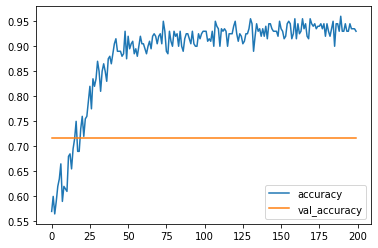

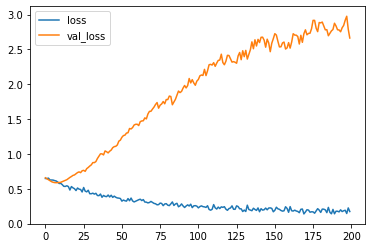

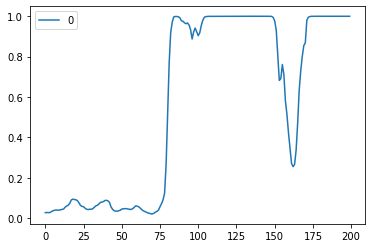

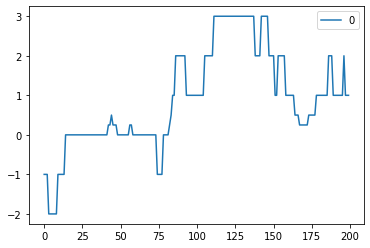

In [3]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

# 주식 데이터 및 금 시세 데이터를 로짓
df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

# 조정종가를 종가로 나눈 값 : 이는 단순 재무 수치 이외의 기업적인 이벤트를 의미
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)
df['gap'] = df['adj']/df['close'] 

# 5일 평균 조정종가 산정, 타겟 블록화
df['mov5'] = df['adj'].rolling(5).mean()

# 특정 기간 이후의 수익율 산정(1년치 데이터 학습 모델의 경우 향후 6개월까지만)
df['1d'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-119) )/df['mov5'].shift(-120)
df['1w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-115) )/df['mov5'].shift(-120) 
df['2w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-110) )/df['mov5'].shift(-120) 
df['4w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-100) )/df['mov5'].shift(-120)
df['6w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-90) )/df['mov5'].shift(-120) 
df['8w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-80) )/df['mov5'].shift(-120) 
df['10w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-70) )/df['mov5'].shift(-120)
df['12w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-60) )/df['mov5'].shift(-120)
df['18w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-30) )/df['mov5'].shift(-120) 
df['24w'] = ( df['mov5'].shift(-120) - df['mov5'] )/df['mov5'].shift(-120)

df['1d'] = df['1d'].shift(120)
df['1w'] =df['1w'].shift(120)
df['2w'] = df['2w'].shift(120)
df['4w'] = df['4w'].shift(120)
df['6w'] = df['6w'].shift(120)
df['8w'] = df['8w'].shift(120)
df['10w'] = df['10w'].shift(120)
df['12w'] = df['12w'].shift(120)
df['18w'] = df['18w'].shift(120)
df['24w'] = df['24w'].shift(120)

# 현실적인 수익율을 보수적으로 타겟팅 : 상위 수익율 3,4,5위位의 평균
df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3 

# na가 하나라도 있는 열을 모두 제거
df = df.dropna(axis=0) 
# 250 주식거래일이 1년이라고 했을 때, 그전의 50거래일이 사전에 영향을 줄 수 있다.
df = df.iloc[-300:,:]

df['return'].describe()

# 수치로 되어있는 수익율을 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result


df['return02'] = df.apply(scaler01,axis=1)

from tensorflow.keras.callbacks import ModelCheckpoint # 좋은 성능을 보인 모델만 저장

modelpath = "/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5" # 저장할 모델 경로와 이름 지정
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'loss', mode = 'auto', verbose = 1, save_best_only = True) 
# reverse 데이터이기 때문에 monitor하는 값을 loss로 지정, 만약 정방향 데이터(과거 데이터가 제일 위에 있는)라면 val_loss 값을 monitoring

from tensorflow.keras.callbacks import EarlyStopping # 과대적합을 피하기 위해 조기에 멈추도록
early_stop = EarlyStopping(monitor = 'loss', patience = 30) # 마찬가지로 loss값을 기준으로 개선되지 않으면 30번만 참다가 정지

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values # 변수(X) 지정
target = df['return02'].values # 구하고자하는 값, return02는 구간화한 수익율

T = 5 # 1년 데이터를 학습하는 모델이기 때문에 T값을 제일 작은 5로 설정함으로써 5일치 데이터를 기반으로 그 주의 수익율 예측
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건 

# Xtest /Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4) # 내부 조건

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

# EnSemble을 만들기 위한 사전 작업 : 1년 데이터 분석이기 때문에 LSTM보다 리소스 요구가 적고, 짧은 시계열 데이터에 대한 분석 성능이 좋은 GRU 두개를 붙여서 사용
# 3년 데이터는 GRU + LSTM, 12년 데이터는 GRU + LSTM + SIMPLERnn 으로 Ensemble 모델 구성

i = Input(shape=(T,D))

gru = GRU(50, dropout=0.2, recurrent_dropout=0.2) # 모델의 내부에 짜여진 알고리즘 중 일정한 비율을 제거하는 dropout과 recurrent_dropout 사용.
                                                  # 이를 통해 단조로운 모델이 충분학 학습 전에 결론을 먼저 내려버리는 과대적합을 방지하고, 다양한 모델을 섞어서 사용하는 효과
left_input = Input(shape=(T,D))
left_output = gru(left_input)
#데이터 분량에 따라 lstm과 gru 구분 해서 사용 가능 

gru = GRU(50,  dropout=0.4, recurrent_dropout=0.4)
right_input = Input(shape= (T,D))
right_output = gru(right_input)

# merge
merged = tf.keras.layers.concatenate([left_output, right_output], axis = -1) #분류기 제일 위에 놓기
merged = Dropout(rate=0.7)(merged) # 왼쪽과 오른쪽에서 나온 50개의 결과값 안에 짜여진 알고리즘의 70%를 랜덤하게 제거
merged = Dense(256, activation='relu')(merged) # 제거된 알고리즘과 50개의 결과값을 input으로 받아들여 relu라는 activation 방식으로 분석해 256개의 output 도출
merged = Dropout(rate=0.7)(merged) # 왼쪽과 오른쪽에서 나온 256개의 결과값 안에 짜여진 알고리즘의 70%를 랜덤하게 제거
merged = Dense(5, LeakyReLU(alpha=0.1))(merged) # 제거된 알고리즘과 256개의 결과값을 input으로 받아들여 LeakyReLU라는 activation 방식으로 분석해 5개의 output 도출.
                                                # 여기서 만들어진 alpha값은 relu를 사용하는 과정에서 일반화 등에 따라 0으로 처리되는 변수를 일정 음수로 만들어, 과대적합을 방지해주는 효과.
                                                # 즉, 의도치 않게 이상한 방향으로 섣부르게 결론 지어지는 과정에서 역방향으로 파동을 주어 올바르게 움직일 수 있도록 도와주는 정도.
                                                # alpha값이 너무 커지면 대체적으로 잘가고 있던 흐름이 크게 흔들릴 수도 있다.
predictions = tf.keras.layers.Dense(1, activation = 'sigmoid')(merged) # 결과값을 분류classifying의 형태로 도출. 나오는 값은 1과 0 사이의 실수

model = Model([left_input, right_input], predictions)

model.compile(
    loss = 'binary_crossentropy',   # 나오는 값의 결과가 두 개(0과 1)일 때는 binary, 그 이상일 때는 categorical, 원하는 목표값이 드물 때는 sparse_categorical_crossentropy 사용
    sample_weight_mode = 'temporal', # 분석하는 결과값이 2차원(시계열과 변수로 이루어진)일 경우, 각 분석 경우마다 변수의 가중치를 조정. 기본값은 none
    optimizer = SGD(lr = 0.01,decay = 0.000001 , momentum = 0.1, nesterov=False), # SGC, Adam, Nadam, Adamax 중 선택
                                                                                  # lr은 한 번의 학습으로 얼마나 학습율을 쌓을 것인지이며, 데이터 양이 적기 때문에 높은 수준으로 사용
                                                                                  # decay는 이러한 학습율을 학습이 반볼될 때마다 얼마나 줄일 것인지(최근 경향 반영)
                                                                                  # momentum의 경우 기존 결과와 다른 수준의 결과가 나왔을 때 그것을 신뢰하는 수준
                                                                                  # nesterov는 momentum과 유사하게 기존과 다른 데이터가 나왔을 때 기존 데이터를 반복적으로 참고할 것인지 여부
    metrics = ['accuracy'],
)

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

# 훈련 결과를 시각화 - 정확도
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

# 훈련 결과를 시각화 - 로스
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

# 훈련 결과를 시각화 - 예측값과 실제값
pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


# #2 AMAZON

train data % : 28.999999999999996 test data % : 5.0
Epoch 1/200
13/13 [==============================] - 3s 52ms/step - loss: 0.6433 - accuracy: 0.7800 - val_loss: 0.4214 - val_accuracy: 0.7789

Epoch 00001: loss did not improve from 0.13813
Epoch 2/200
13/13 [==============================] - 0s 11ms/step - loss: 0.3588 - accuracy: 0.8400 - val_loss: 0.2716 - val_accuracy: 0.9474

Epoch 00002: loss did not improve from 0.13813
Epoch 3/200
13/13 [==============================] - 0s 12ms/step - loss: 0.3552 - accuracy: 0.8300 - val_loss: 0.2616 - val_accuracy: 0.9474

Epoch 00003: loss did not improve from 0.13813
Epoch 4/200
13/13 [==============================] - 0s 11ms/step - loss: 0.3150 - accuracy: 0.8700 - val_loss: 0.2605 - val_accuracy: 0.9474

Epoch 00004: loss did not improve from 0.13813
Epoch 5/200
13/13 [==============================] - 0s 11ms/step - loss: 0.3307 - accuracy: 0.8700 - val_loss: 0.2566 - val_accuracy: 0.9474

Epoch 00005: loss did not improve from 0.1381

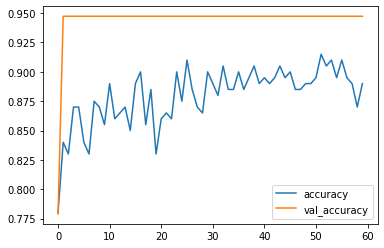

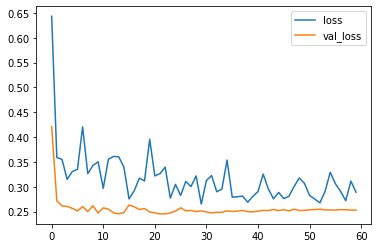

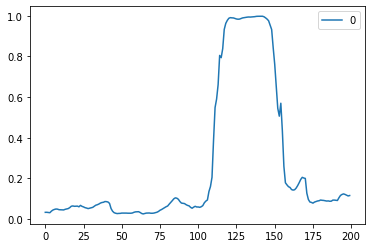

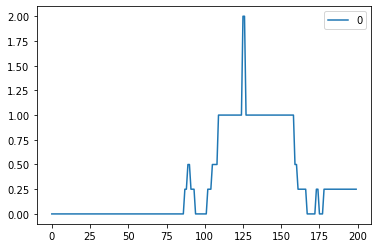

In [4]:
df = pd.read_csv("/content/gdrive/My Drive/AMZN.csv")


df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-119) )/df['mov5'].shift(-120)
df['1w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-115) )/df['mov5'].shift(-120) 
df['2w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-110) )/df['mov5'].shift(-120) 
df['4w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-100) )/df['mov5'].shift(-120)
df['6w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-90) )/df['mov5'].shift(-120) 
df['8w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-80) )/df['mov5'].shift(-120) 
df['10w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-70) )/df['mov5'].shift(-120)
df['12w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-60) )/df['mov5'].shift(-120)
df['18w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-30) )/df['mov5'].shift(-120) 
df['24w'] = ( df['mov5'].shift(-120) - df['mov5'] )/df['mov5'].shift(-120)

df['1d'] = df['1d'].shift(120)
df['1w'] =df['1w'].shift(120)
df['2w'] = df['2w'].shift(120)
df['4w'] = df['4w'].shift(120)
df['6w'] = df['6w'].shift(120)
df['8w'] = df['8w'].shift(120)
df['10w'] = df['10w'].shift(120)
df['12w'] = df['12w'].shift(120)
df['18w'] = df['18w'].shift(120)
df['24w'] = df['24w'].shift(120)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


# #3 TESLA

train data % : 41.0 test data % : 3.0
Epoch 1/200
13/13 [==============================] - 3s 51ms/step - loss: 0.3611 - accuracy: 0.8400 - val_loss: 0.0832 - val_accuracy: 0.9895

Epoch 00001: loss did not improve from 0.13813
Epoch 2/200
13/13 [==============================] - 0s 12ms/step - loss: 0.4118 - accuracy: 0.8250 - val_loss: 0.0822 - val_accuracy: 0.9895

Epoch 00002: loss did not improve from 0.13813
Epoch 3/200
13/13 [==============================] - 0s 11ms/step - loss: 0.4245 - accuracy: 0.8200 - val_loss: 0.0824 - val_accuracy: 0.9895

Epoch 00003: loss did not improve from 0.13813
Epoch 4/200
13/13 [==============================] - 0s 12ms/step - loss: 0.2781 - accuracy: 0.8800 - val_loss: 0.0813 - val_accuracy: 0.9895

Epoch 00004: loss did not improve from 0.13813
Epoch 5/200
13/13 [==============================] - 0s 11ms/step - loss: 0.3197 - accuracy: 0.8500 - val_loss: 0.0797 - val_accuracy: 0.9895

Epoch 00005: loss did not improve from 0.13813
Epoch 6/200


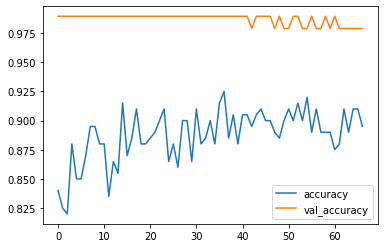

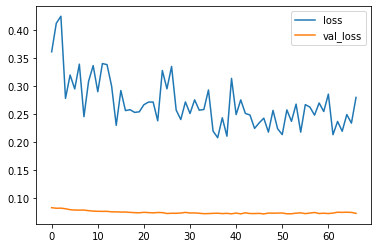

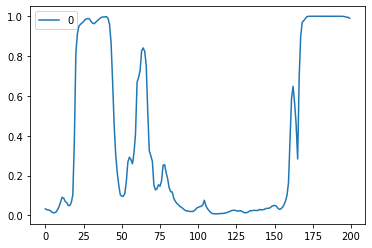

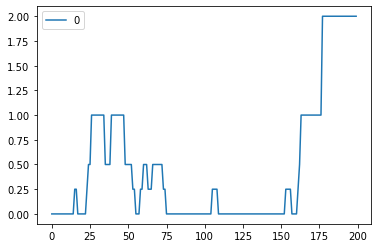

In [5]:
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])
df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-119) )/df['mov5'].shift(-120)
df['1w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-115) )/df['mov5'].shift(-120) 
df['2w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-110) )/df['mov5'].shift(-120) 
df['4w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-100) )/df['mov5'].shift(-120)
df['6w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-90) )/df['mov5'].shift(-120) 
df['8w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-80) )/df['mov5'].shift(-120) 
df['10w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-70) )/df['mov5'].shift(-120)
df['12w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-60) )/df['mov5'].shift(-120)
df['18w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-30) )/df['mov5'].shift(-120) 
df['24w'] = ( df['mov5'].shift(-120) - df['mov5'] )/df['mov5'].shift(-120)

df['1d'] = df['1d'].shift(120)
df['1w'] =df['1w'].shift(120)
df['2w'] = df['2w'].shift(120)
df['4w'] = df['4w'].shift(120)
df['6w'] = df['6w'].shift(120)
df['8w'] = df['8w'].shift(120)
df['10w'] = df['10w'].shift(120)
df['12w'] = df['12w'].shift(120)
df['18w'] = df['18w'].shift(120)
df['24w'] = df['24w'].shift(120)


df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result


df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()


pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


# #4 APPLE

train data % : 63.5 test data % : 28.000000000000004
Epoch 1/200
13/13 [==============================] - 3s 69ms/step - loss: 0.4618 - accuracy: 0.7850 - val_loss: 2.9758 - val_accuracy: 0.4211

Epoch 00001: loss did not improve from 0.13813
Epoch 2/200
13/13 [==============================] - 0s 11ms/step - loss: 0.3102 - accuracy: 0.8450 - val_loss: 3.8516 - val_accuracy: 0.2947

Epoch 00002: loss did not improve from 0.13813
Epoch 3/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2481 - accuracy: 0.8850 - val_loss: 4.7987 - val_accuracy: 0.2947

Epoch 00003: loss did not improve from 0.13813
Epoch 4/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2153 - accuracy: 0.9050 - val_loss: 5.3855 - val_accuracy: 0.2947

Epoch 00004: loss did not improve from 0.13813
Epoch 5/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2197 - accuracy: 0.9000 - val_loss: 5.7037 - val_accuracy: 0.2947

Epoch 00005: loss did not improve from 0.138

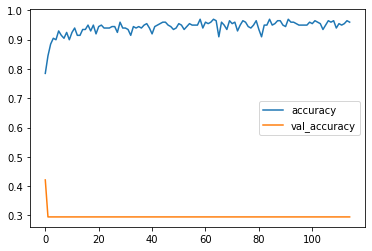

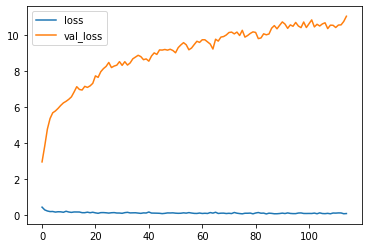

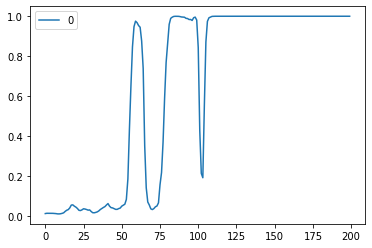

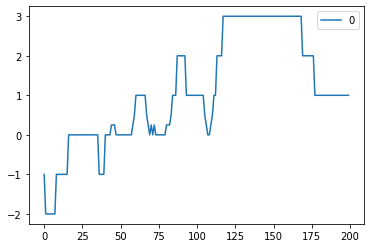

In [6]:
df = pd.read_csv("/content/gdrive/My Drive/AAPL.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-119) )/df['mov5'].shift(-120)
df['1w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-115) )/df['mov5'].shift(-120) 
df['2w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-110) )/df['mov5'].shift(-120) 
df['4w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-100) )/df['mov5'].shift(-120)
df['6w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-90) )/df['mov5'].shift(-120) 
df['8w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-80) )/df['mov5'].shift(-120) 
df['10w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-70) )/df['mov5'].shift(-120)
df['12w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-60) )/df['mov5'].shift(-120)
df['18w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-30) )/df['mov5'].shift(-120) 
df['24w'] = ( df['mov5'].shift(-120) - df['mov5'] )/df['mov5'].shift(-120)

df['1d'] = df['1d'].shift(120)
df['1w'] =df['1w'].shift(120)
df['2w'] = df['2w'].shift(120)
df['4w'] = df['4w'].shift(120)
df['6w'] = df['6w'].shift(120)
df['8w'] = df['8w'].shift(120)
df['10w'] = df['10w'].shift(120)
df['12w'] = df['12w'].shift(120)
df['18w'] = df['18w'].shift(120)
df['24w'] = df['24w'].shift(120)


df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result


df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


# #5 INTEL

train data % : 49.5 test data % : 13.0
Epoch 1/200
13/13 [==============================] - 3s 52ms/step - loss: 1.7316 - accuracy: 0.8000 - val_loss: 7.7485 - val_accuracy: 0.1368

Epoch 00001: loss did not improve from 0.08544
Epoch 2/200
13/13 [==============================] - 0s 11ms/step - loss: 1.2392 - accuracy: 0.7850 - val_loss: 5.4421 - val_accuracy: 0.1368

Epoch 00002: loss did not improve from 0.08544
Epoch 3/200
13/13 [==============================] - 0s 12ms/step - loss: 1.1213 - accuracy: 0.7400 - val_loss: 3.9360 - val_accuracy: 0.1368

Epoch 00003: loss did not improve from 0.08544
Epoch 4/200
13/13 [==============================] - 0s 11ms/step - loss: 0.8129 - accuracy: 0.7600 - val_loss: 3.1432 - val_accuracy: 0.1368

Epoch 00004: loss did not improve from 0.08544
Epoch 5/200
13/13 [==============================] - 0s 11ms/step - loss: 0.7487 - accuracy: 0.7400 - val_loss: 2.5699 - val_accuracy: 0.1368

Epoch 00005: loss did not improve from 0.08544
Epoch 6/200

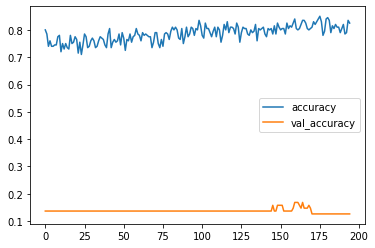

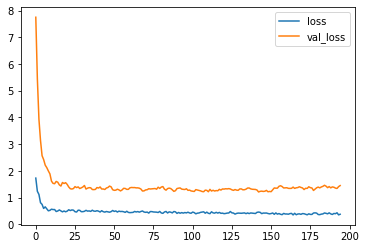

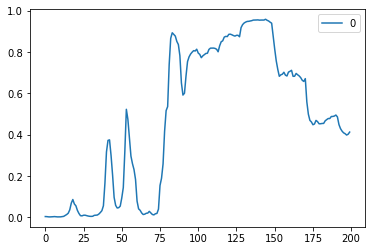

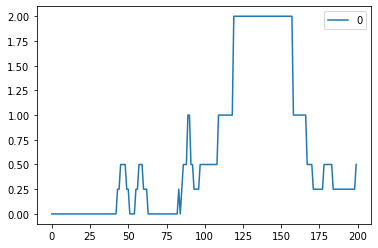

In [7]:
df = pd.read_csv("/content/gdrive/My Drive/INTC.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-119) )/df['mov5'].shift(-120)
df['1w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-115) )/df['mov5'].shift(-120) 
df['2w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-110) )/df['mov5'].shift(-120) 
df['4w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-100) )/df['mov5'].shift(-120)
df['6w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-90) )/df['mov5'].shift(-120) 
df['8w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-80) )/df['mov5'].shift(-120) 
df['10w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-70) )/df['mov5'].shift(-120)
df['12w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-60) )/df['mov5'].shift(-120)
df['18w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-30) )/df['mov5'].shift(-120) 
df['24w'] = ( df['mov5'].shift(-120) - df['mov5'] )/df['mov5'].shift(-120)


df['1d'] = df['1d'].shift(120)
df['1w'] =df['1w'].shift(120)
df['2w'] = df['2w'].shift(120)
df['4w'] = df['4w'].shift(120)
df['6w'] = df['6w'].shift(120)
df['8w'] = df['8w'].shift(120)
df['10w'] = df['10w'].shift(120)
df['12w'] = df['12w'].shift(120)
df['18w'] = df['18w'].shift(120)
df['24w'] = df['24w'].shift(120)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result


df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


# #6 AMD

train data % : 66.5 test data % : 48.0
Epoch 1/200
13/13 [==============================] - 3s 52ms/step - loss: 0.2333 - accuracy: 0.9350 - val_loss: 6.0420 - val_accuracy: 0.5053

Epoch 00001: loss did not improve from 0.08544
Epoch 2/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2303 - accuracy: 0.9100 - val_loss: 5.8454 - val_accuracy: 0.5053

Epoch 00002: loss did not improve from 0.08544
Epoch 3/200
13/13 [==============================] - 0s 12ms/step - loss: 0.3045 - accuracy: 0.9100 - val_loss: 5.7695 - val_accuracy: 0.5053

Epoch 00003: loss did not improve from 0.08544
Epoch 4/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2178 - accuracy: 0.9250 - val_loss: 5.8634 - val_accuracy: 0.5053

Epoch 00004: loss did not improve from 0.08544
Epoch 5/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2120 - accuracy: 0.9400 - val_loss: 5.8249 - val_accuracy: 0.5053

Epoch 00005: loss did not improve from 0.08544
Epoch 6/200

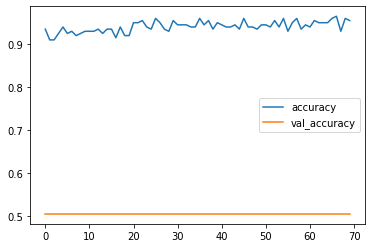

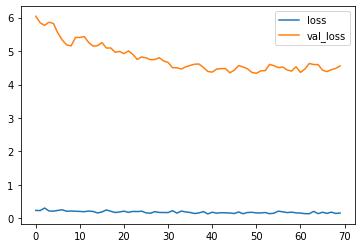

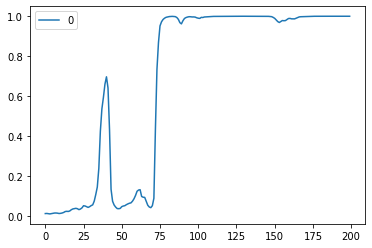

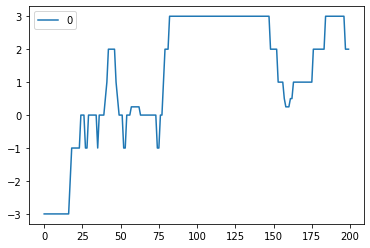

In [8]:
df = pd.read_csv("/content/gdrive/My Drive/AMD.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-119) )/df['mov5'].shift(-120)
df['1w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-115) )/df['mov5'].shift(-120) 
df['2w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-110) )/df['mov5'].shift(-120) 
df['4w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-100) )/df['mov5'].shift(-120)
df['6w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-90) )/df['mov5'].shift(-120) 
df['8w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-80) )/df['mov5'].shift(-120) 
df['10w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-70) )/df['mov5'].shift(-120)
df['12w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-60) )/df['mov5'].shift(-120)
df['18w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-30) )/df['mov5'].shift(-120) 
df['24w'] = ( df['mov5'].shift(-120) - df['mov5'] )/df['mov5'].shift(-120)


df['1d'] = df['1d'].shift(120)
df['1w'] =df['1w'].shift(120)
df['2w'] = df['2w'].shift(120)
df['4w'] = df['4w'].shift(120)
df['6w'] = df['6w'].shift(120)
df['8w'] = df['8w'].shift(120)
df['10w'] = df['10w'].shift(120)
df['12w'] = df['12w'].shift(120)
df['18w'] = df['18w'].shift(120)
df['24w'] = df['24w'].shift(120)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


# #7 RE:STARBUX

train data % : 58.5 test data % : 68.0
Epoch 1/200
13/13 [==============================] - 3s 52ms/step - loss: 0.4607 - accuracy: 0.8950 - val_loss: 4.0967 - val_accuracy: 0.7158

Epoch 00001: loss did not improve from 0.08544
Epoch 2/200
13/13 [==============================] - 0s 13ms/step - loss: 0.1704 - accuracy: 0.9450 - val_loss: 3.5717 - val_accuracy: 0.7158

Epoch 00002: loss did not improve from 0.08544
Epoch 3/200
13/13 [==============================] - 0s 11ms/step - loss: 0.1751 - accuracy: 0.9550 - val_loss: 3.4129 - val_accuracy: 0.7158

Epoch 00003: loss did not improve from 0.08544
Epoch 4/200
13/13 [==============================] - 0s 11ms/step - loss: 0.2353 - accuracy: 0.9250 - val_loss: 3.2683 - val_accuracy: 0.7158

Epoch 00004: loss did not improve from 0.08544
Epoch 5/200
13/13 [==============================] - 0s 11ms/step - loss: 0.1581 - accuracy: 0.9500 - val_loss: 3.3071 - val_accuracy: 0.7158

Epoch 00005: loss did not improve from 0.08544
Epoch 6/200

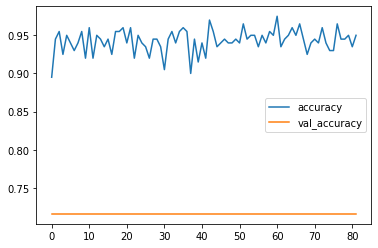

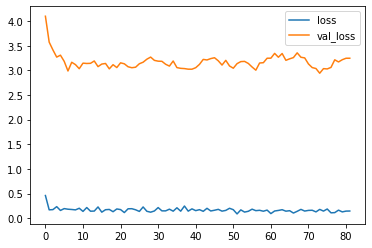

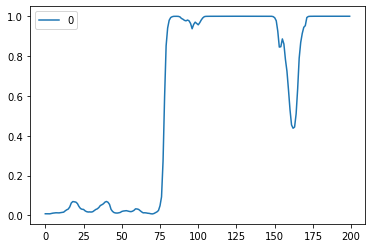

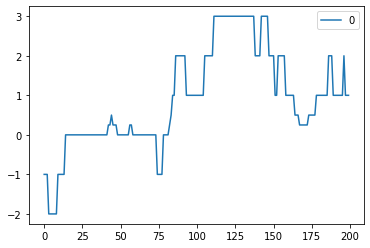

In [9]:
df = pd.read_csv("/content/gdrive/My Drive/SBUX_rev.2.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()

df['1d'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-119) )/df['mov5'].shift(-120)
df['1w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-115) )/df['mov5'].shift(-120) 
df['2w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-110) )/df['mov5'].shift(-120) 
df['4w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-100) )/df['mov5'].shift(-120)
df['6w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-90) )/df['mov5'].shift(-120) 
df['8w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-80) )/df['mov5'].shift(-120) 
df['10w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-70) )/df['mov5'].shift(-120)
df['12w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-60) )/df['mov5'].shift(-120)
df['18w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-30) )/df['mov5'].shift(-120) 
df['24w'] = ( df['mov5'].shift(-120) - df['mov5'] )/df['mov5'].shift(-120)


df['1d'] = df['1d'].shift(120)
df['1w'] =df['1w'].shift(120)
df['2w'] = df['2w'].shift(120)
df['4w'] = df['4w'].shift(120)
df['6w'] = df['6w'].shift(120)
df['8w'] = df['8w'].shift(120)
df['10w'] = df['10w'].shift(120)
df['12w'] = df['12w'].shift(120)
df['18w'] = df['18w'].shift(120)
df['24w'] = df['24w'].shift(120)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df.iloc[-300:,:]

df['return'].describe()

# 수익율을 다시 구간화
def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif -0.2 < row['return'] <= -0.1 : result = -1     # 확정 손실 구간
  elif -0.3 < row['return'] <= -0.2 : result = -2     # 높은 손실 구간
  elif row['return'] <= -0.3 : result = -3            # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

input_data = df[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return02'].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# Scaling - must
Ntrain = len(input_data) * 2 // 3
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

pd.DataFrame(target).describe()

# Xtrain / Ytrain
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain) :
  X_train[t,:,:] = input_data[t:t+T]
  Y_train[t] = (target [t+T]>0.4) # 내부 조건

# Xtest Ytest

X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
    t = u + Ntrain
    X_test [u, :,:] = input_data[t:t+T]
    Y_test [u] = (target [t+T] >0.4)

# 정답 비율
print("train data % :",round(Y_train.sum()/(len(target)*2/3),4)*100, "test data % :",round(Y_test.sum()/(len(target)*1/3),4)*100)

from tensorflow.keras.models import load_model

model = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")

# 모델 객체 만들고 훈련
r = model.fit([X_train, X_train], 
          Y_train,
          batch_size = 16,
          epochs = 200,
          validation_data = ([X_test, X_test], Y_test),
          callbacks = [early_stop,checkpointer] 
          )

#Converge
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

#Converge
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()


pd.DataFrame(model.predict([X_train, X_train])).plot()
pd.DataFrame(target[:Ntrain]).plot()


# reverse model과 정식 모델의 예측을 그려보기

300
295
         date     pred1     pred2    result  result02
0    20180924  0.999999  0.000010  0.001584       0.0
1    20180925  0.999999  0.000010 -0.007558       0.0
2    20180926  0.999998  0.000013 -0.014897       0.0
3    20180927  0.999995  0.000021 -0.021338       0.0
4    20180928  0.999996  0.000013 -0.029268       0.0
..        ...       ...       ...       ...       ...
290  20191118  0.999998  0.000295 -0.059381       0.0
291  20191119  0.999997  0.000368 -0.061932       0.0
292  20191120  0.999997  0.000489 -0.064506       0.0
293  20191121  0.999994  0.000729 -0.067917       0.0
294  20191122  0.999992  0.000477 -0.071833       0.0

[295 rows x 5 columns]


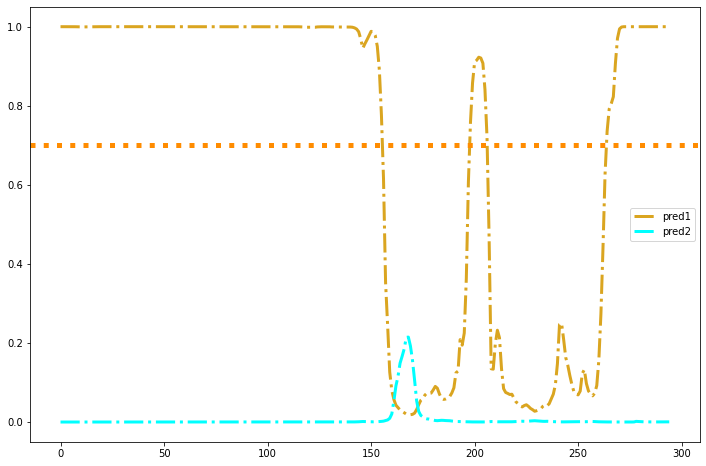

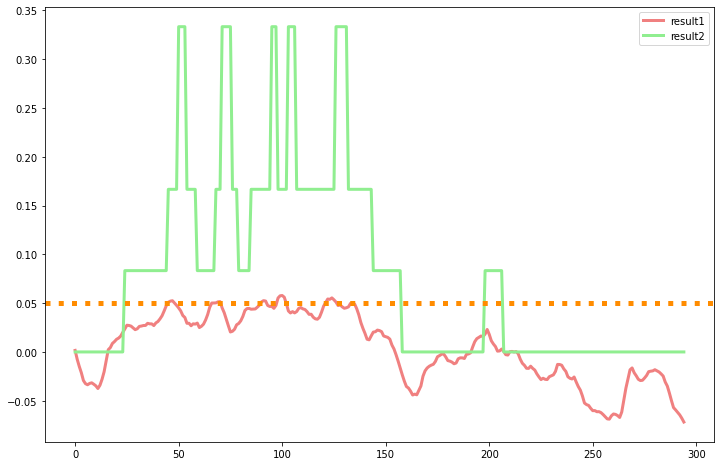

In [10]:
df = pd.read_csv("/content/gdrive/My Drive/TSLA.csv")

df.columns = ['date', 'open', 'high', 'low', 'close', 'adj','volume','web','news','youtube','image','gold']

df.iloc[:, 1:6] = np.log(df.iloc[:,1:6])
df['gold'] = np.log(df['gold'])

df.sort_values(by = ['date'], axis=0, ascending=False, inplace = True)

df['gap'] = df['adj']/df['close'] 

df['mov5'] = df['adj'].rolling(5).mean()


df['1d'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-119) )/df['mov5'].shift(-120)
df['1w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-115) )/df['mov5'].shift(-120) 
df['2w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-110) )/df['mov5'].shift(-120) 
df['4w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-100) )/df['mov5'].shift(-120)
df['6w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-90) )/df['mov5'].shift(-120) 
df['8w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-80) )/df['mov5'].shift(-120) 
df['10w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-70) )/df['mov5'].shift(-120)
df['12w'] = ( df['mov5'].shift(-120) - df['mov5'].shift(-60) )/df['mov5'].shift(-120)
df['18w'] = ( df['mov5'].shift(-120)- df['mov5'].shift(-30) )/df['mov5'].shift(-120) 
df['24w'] = ( df['mov5'].shift(-120) - df['mov5'] )/df['mov5'].shift(-120)


df['1d'] = df['1d'].shift(120)
df['1w'] =df['1w'].shift(120)
df['2w'] = df['2w'].shift(120)
df['4w'] = df['4w'].shift(120)
df['6w'] = df['6w'].shift(120)
df['8w'] = df['8w'].shift(120)
df['10w'] = df['10w'].shift(120)
df['12w'] = df['12w'].shift(120)
df['18w'] = df['18w'].shift(120)
df['24w'] = df['24w'].shift(120)

df['return'] = (np.sort(df.iloc[:,14:],axis=1)[:,7] + np.sort(df.iloc[:,14:],axis=1)[:,6] + np.sort(df.iloc[:,14:],axis=1)[:,5])/3

df = df.dropna(axis=0)
df = df[111:411]

df['return'].describe()

def scaler01(row) :
  if row['return'] >= 0.2 : result = 3                # 초고수익율 구간
  elif 0.2 > row['return'] >= 0.1 : result = 2        # 고수익율 구간
  elif 0.1 > row['return'] >= 0.05 : result = 1       # 수익율 구간
  elif 0.05 > row['return'] >= 0.03 : result = 0.5    # 낮은 수익율 구간
  elif 0.03 > row['return'] >= 0.01 : result = 0.25   # 보전 구간(손실은 안나는)
  elif row['return'] < -0.1 : result = -1              # 확정 손실 구간
  elif row['return'] < -0.2 : result = -2              # 높은 손실 구간
  elif row['return'] < -0.3 : result = -3              # 초고 손실 구간
  else : result = 0                                   # 손실 구간
  return result

df['return02'] = df.apply(scaler01,axis=1)

df2 = df.dropna(axis=0)

input_data = df2[['open', 'high', 'low', 'close','volume', 'adj', 'mov5', 'web','news','youtube','image','gold','gap']].values
target = df['return'].values
target2 = df['return02'].iloc[5:].values
date = df['date'].iloc[5:].values

T = 5
D = input_data.shape[1] 
N = len(input_data) - T

# # Scaling - must
Ntrain = len(input_data)
scaler = MinMaxScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

# Xtrain / Ytrain
X_2020 = np.zeros((N, T, D))

for t in range(N) :
  X_2020[t,:,:] = input_data[t:t+T]

from tensorflow.keras.models import load_model
model1 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03r.hdf5")
model1_pred = model1.predict([X_2020,X_2020])
print(len(input_data))

###

from tensorflow.keras.models import load_model
model2 = load_model("/content/gdrive/My Drive/Colab Notebooks/model/stock_03.hdf5")
model2_pred = model2.predict([X_2020,X_2020])
print(len(model2_pred))

pred_01 = np.zeros(len(model1_pred))
pred_02 = np.zeros(len(model1_pred))

i = 0

for i in range(len(model1_pred)) :
  pred_01[i] = model1_pred[i]
  pred_02[i] = model2_pred[i]

df4 = pd.DataFrame()
df4['date'] = pd.Series(date)
df4['pred1'] = pd.Series(pred_01)
df4['pred2'] = pd.Series(pred_02)
df4['result'] = pd.Series(target)
df4['result02'] = pd.Series(target2)

df4.sort_values(by = ['date'], axis=0, ascending=True, inplace = True)

# df4 = df4.dropna(axis=0)

df4.to_csv("/content/gdrive/My Drive/dataset_test.csv", index=False)
df = pd.read_csv("/content/gdrive/My Drive/dataset_test.csv")
print(df)

# plt.rcParams['lines.linestyle'] = '-'
plt.figure(figsize=(12,8))
plt.plot(df['pred1'],label ='pred1' , color = 'goldenrod', linestyle = '-.', linewidth = 3)
plt.plot(df['pred2'],label ='pred2' , color = 'cyan', linestyle = '-.', linewidth = 3)

plt.axhline( 0.7 , linestyle = ':', color = 'darkorange',linewidth = 5)


plt.legend()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(df['result'],label ='result1', color = 'lightcoral',linestyle = '-' , linewidth = 3)
plt.plot(df['result02']/3,label ='result2', color='lightgreen',linestyle = '-' ,linewidth = 3)

plt.axhline( 0.05 , linestyle = ':', color = 'darkorange',linewidth = 5)


plt.legend()
plt.show()